In [2]:
!pip install networkx matplotlib pandas openpyxl
from google.colab import files
import zipfile
import os

In [3]:
!pip install networkx matplotlib pandas seaborn python-louvain multinetx hypernetx scikit-learn --quiet

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import multinetx as mx
import hypernetx as hnx
from collections import Counter
from networkx.algorithms import community
from community import community_louvain
from sklearn.metrics.pairwise import cosine_similarity



In [4]:
from google.colab import files
uploaded = files.upload()
# After upload:
import pandas as pd
df = pd.read_csv("roboBohr.csv")
df.head()


Saving roboBohr.csv to roboBohr (1).csv


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1267,1268,1269,1270,1271,1272,1273,1274,pubchem_id,Eat
0,0,73.516695,17.817765,12.469551,12.458130,12.454607,12.447345,12.433065,12.426926,12.387474,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,25004,-19.013763
1,1,73.516695,20.649126,18.527789,17.891535,17.887995,17.871731,17.852586,17.729842,15.864270,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25005,-10.161019
2,2,73.516695,17.830377,12.512263,12.404775,12.394493,12.391564,12.324461,12.238106,10.423249,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25006,-9.376619
3,3,73.516695,17.875810,17.871259,17.862402,17.850920,17.850440,12.558105,12.557645,12.517583,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25009,-13.776438
4,4,73.516695,17.883818,17.868256,17.864221,17.818540,12.508657,12.490519,12.450098,10.597068,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25011,-8.537140


In [5]:
!pip install networkx matplotlib pandas seaborn python-louvain multinetx hypernetx scikit-learn --quiet

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import multinetx as mx
import hypernetx as hnx
from collections import Counter
from networkx.algorithms import community
from community import community_louvain
from sklearn.metrics.pairwise import cosine_similarity

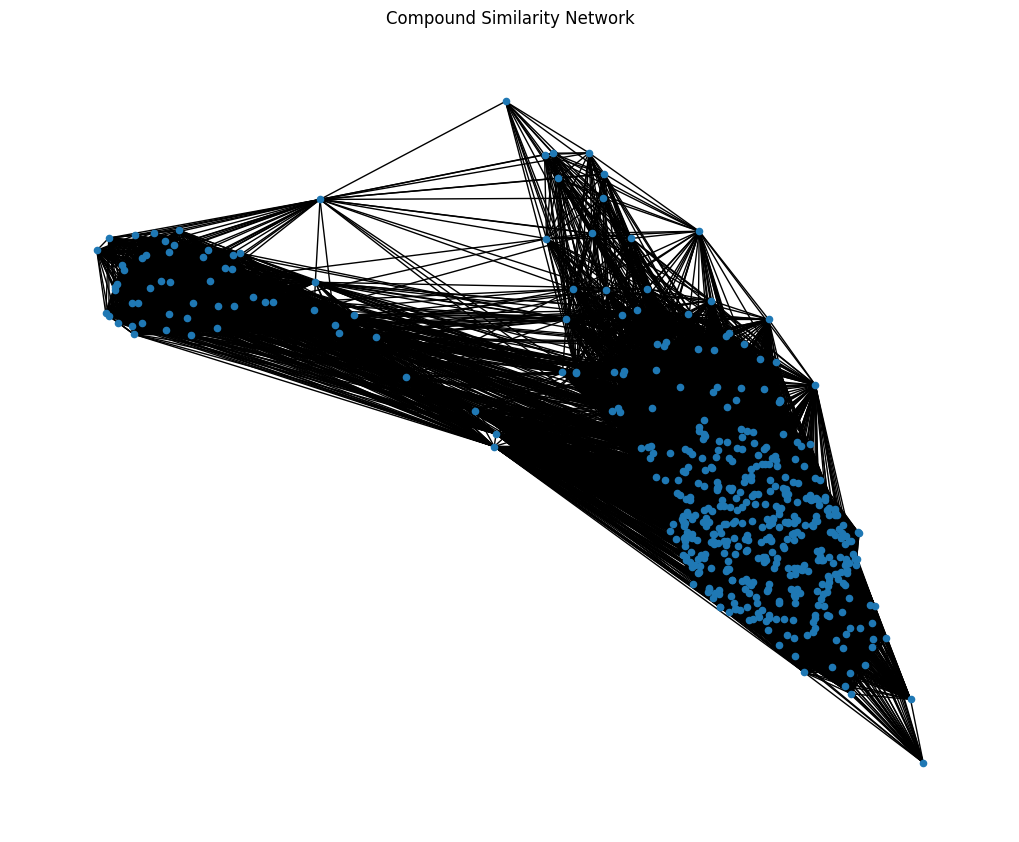

In [6]:
features = df.drop(columns=['Unnamed: 0', 'pubchem_id', 'Eat'])
features = features.select_dtypes(include=[np.number])
features = features.sample(n=500, random_state=42).reset_index(drop=True)

# cosine similarity matrix
similarity_matrix = cosine_similarity(features)
threshold = 0.85  # Reduced to allow more connections  # High similarity threshold

G = nx.Graph()
num_nodes = similarity_matrix.shape[0]
G.add_nodes_from(range(num_nodes))
for i in range(num_nodes):
    for j in range(i+1, num_nodes):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=similarity_matrix[i, j])


plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=False, node_size=20)
plt.title("Compound Similarity Network")
plt.show()


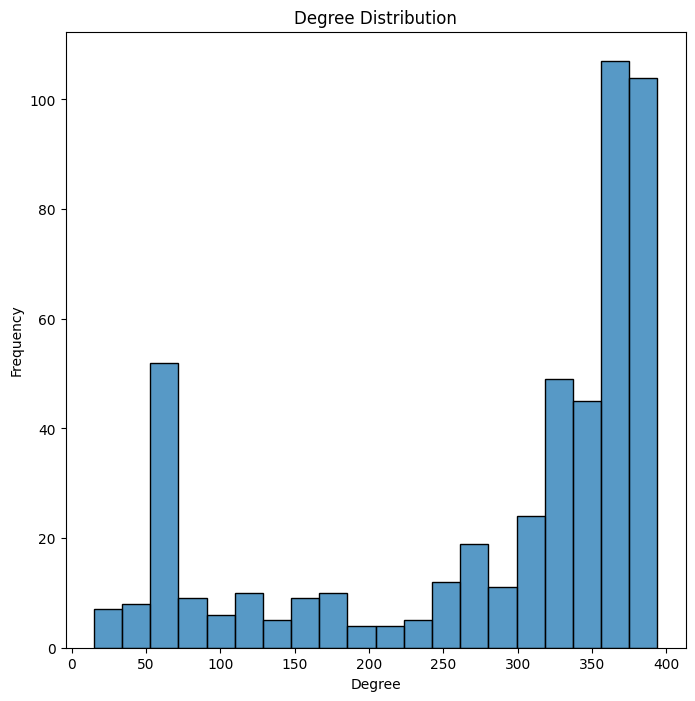

In [9]:
degrees = [d for n, d in G.degree()]
sns.histplot(degrees, bins=20)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

In [8]:
#Maximum Cliques
cliques = list(nx.find_cliques(G))
print(f"Found {len(cliques)} maximal cliques")

Found 2500 maximal cliques


In [10]:
partition = community_louvain.best_partition(G)
modularity_score = community_louvain.modularity(partition, G)
print("Louvain Modularity:", modularity_score)



Louvain Modularity: 0.14012319144046226


In [12]:
def simulate_cascade(graph, removal_fraction=0.1):
    g_copy = graph.copy()
    degree_sorted = sorted(g_copy.degree, key=lambda x: x[1], reverse=True)
    remove_nodes = [n for n, _ in degree_sorted[:int(removal_fraction*len(g_copy))]]
    g_copy.remove_nodes_from(remove_nodes)
    return nx.number_connected_components(g_copy)

print("Components after targeted removal:", simulate_cascade(G))

Components after targeted removal: 1


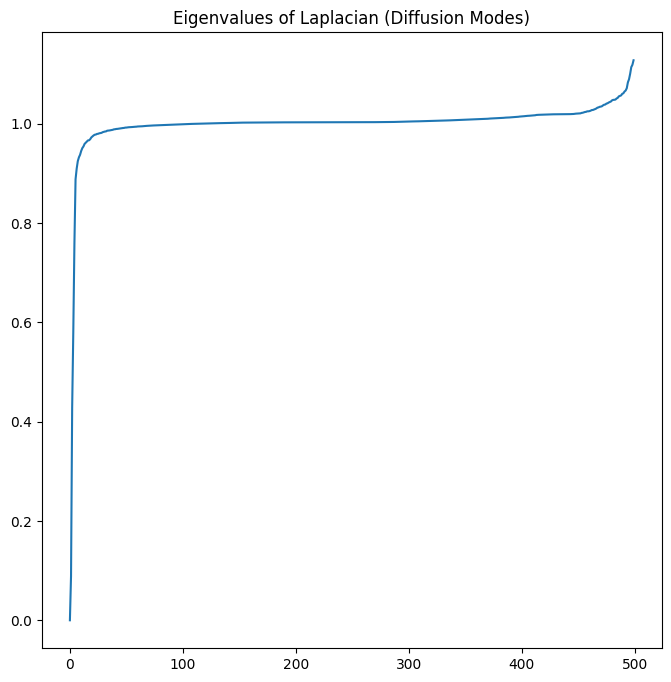

In [13]:
L = nx.normalized_laplacian_matrix(G).todense()
w, v = np.linalg.eig(L)
plt.plot(sorted(w))
plt.title("Eigenvalues of Laplacian (Diffusion Modes)")
plt.show()

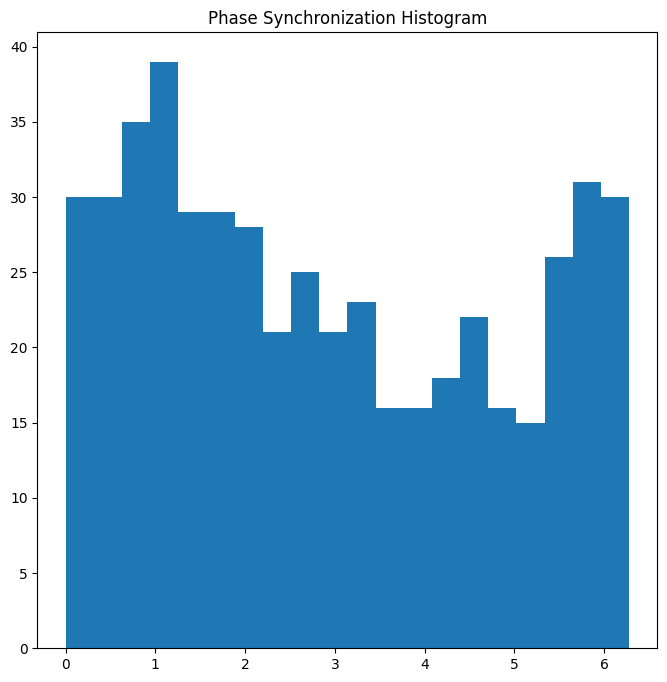

In [14]:
# Synchronization: Kuramoto Model (basic simulation)
N = G.number_of_nodes()
k = 0.5  # coupling strength
theta = np.random.rand(N) * 2 * np.pi

for t in range(100):
    dtheta = np.zeros(N)
    for i in range(N):
        for j in G.neighbors(i):
            dtheta[i] += np.sin(theta[j] - theta[i])
    theta += k * dtheta

plt.hist(np.mod(theta, 2*np.pi), bins=20)
plt.title("Phase Synchronization Histogram")
plt.show()

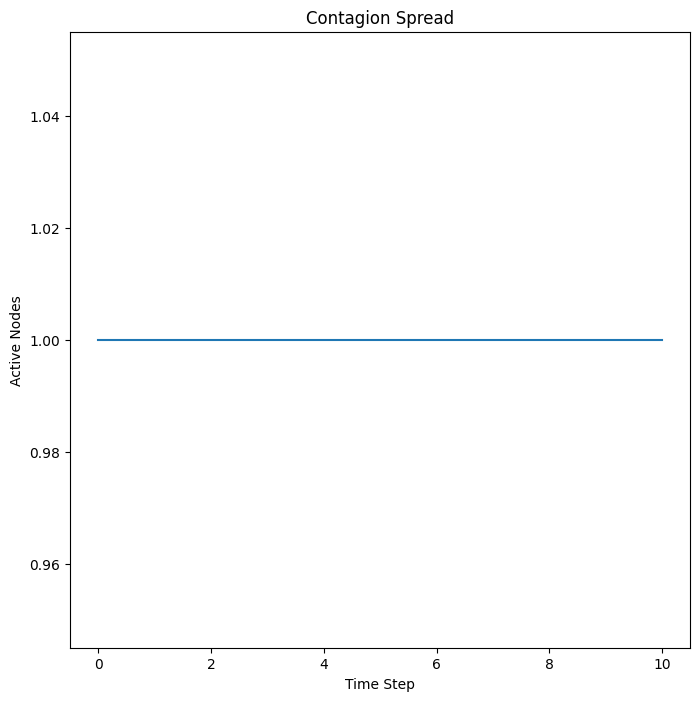

In [15]:
def threshold_model(G, threshold=0.2, steps=10):
    state = {n: 0 for n in G.nodes()}
    seed = np.random.choice(list(G.nodes()))
    state[seed] = 1
    active_counts = [1]
    for _ in range(steps):
        new_state = state.copy()
        for node in G.nodes():
            if state[node] == 0:
                neighbors = list(G.neighbors(node))
                active_neighbors = sum(state[n] for n in neighbors)
                if neighbors and active_neighbors / len(neighbors) > threshold:
                    new_state[node] = 1
        state = new_state
        active_counts.append(sum(state.values()))
    plt.plot(active_counts)
    plt.title("Contagion Spread")
    plt.xlabel("Time Step")
    plt.ylabel("Active Nodes")
    plt.show()

threshold_model(G)

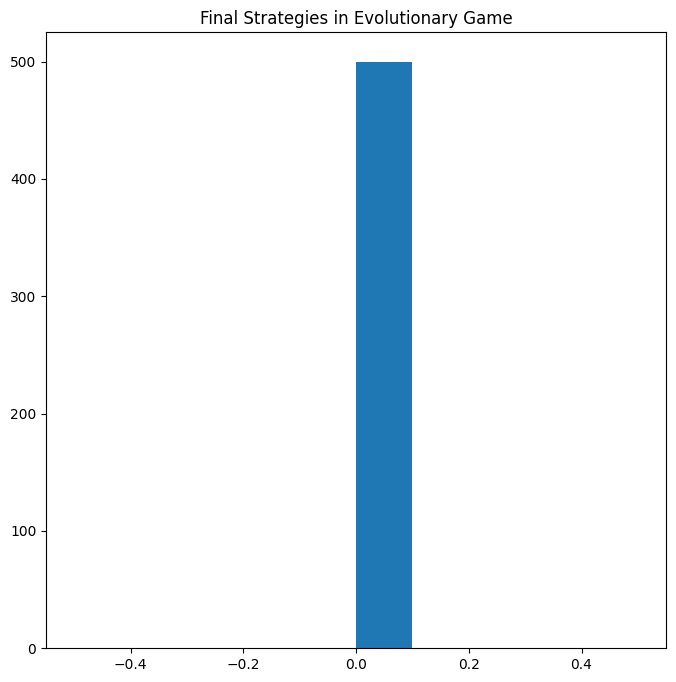

In [16]:
# Evolutionary Games (basic Prisoner's Dilemma)
strategies = {n: np.random.choice([0, 1]) for n in G.nodes()}  # 0 = defect, 1 = cooperate
payoff = {n: 0 for n in G.nodes()}

for _ in range(10):
    for u in G.nodes():
        for v in G.neighbors(u):
            if strategies[u] == 1 and strategies[v] == 1:
                payoff[u] += 3
            elif strategies[u] == 1 and strategies[v] == 0:
                payoff[u] += 0
            elif strategies[u] == 0 and strategies[v] == 1:
                payoff[u] += 5
            else:
                payoff[u] += 1
    # Strategy update
    for n in G.nodes():
        neighbors = list(G.neighbors(n))
        if neighbors:
            best_neighbor = max(neighbors, key=lambda x: payoff[x])
            strategies[n] = strategies[best_neighbor]

plt.hist(list(strategies.values()))
plt.title("Final Strategies in Evolutionary Game")
plt.show()

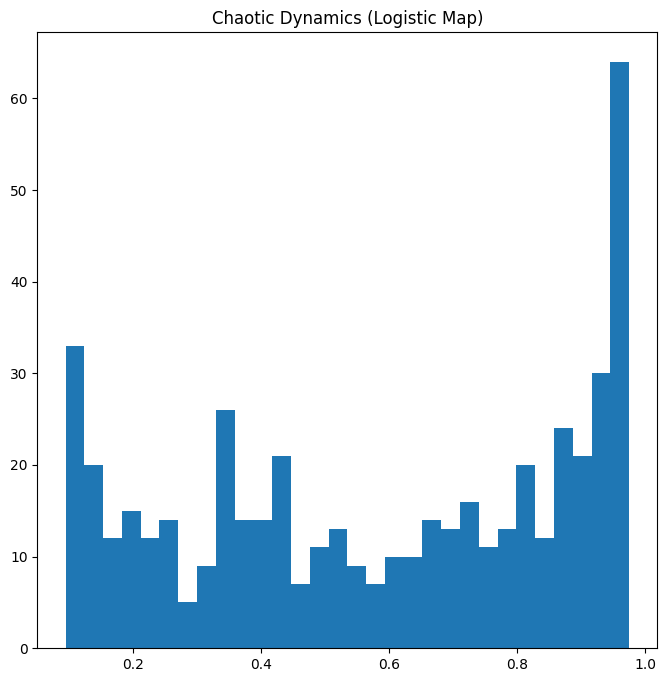

In [17]:
# Chaotic Dynamics: Logistic Map on Network
x = np.random.rand(N)
r = 3.9  # chaotic regime
for _ in range(100):
    x = r * x * (1 - x)

plt.hist(x, bins=30)
plt.title("Chaotic Dynamics (Logistic Map)")
plt.show()


In [19]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


Number of nodes: 500
Number of edges: 71210


In [18]:
# Centrality Measures
centrality = nx.degree_centrality(G)
max_node = max(centrality, key=centrality.get)
print(f"Most central node: {max_node} with centrality {centrality[max_node]:.4f}")

Most central node: 252 with centrality 0.7896


In [20]:
features = df.drop(columns=['Unnamed: 0', 'pubchem_id', 'Eat'])
features = features.select_dtypes(include=[np.number])  # keep only numeric

In [21]:
from sklearn.metrics.pairwise import cosine_similarity


similarity_matrix = cosine_similarity(features)
threshold = 0.95
print(similarity_matrix)


[[1.         0.85982493 0.78848278 ... 0.94414734 0.91787762 0.9178982 ]
 [0.85982493 1.         0.89553981 ... 0.85581401 0.93926085 0.93911082]
 [0.78848278 0.89553981 1.         ... 0.75100454 0.8259751  0.82573453]
 ...
 [0.94414734 0.85581401 0.75100454 ... 1.         0.89521013 0.89536652]
 [0.91787762 0.93926085 0.8259751  ... 0.89521013 1.         0.99998209]
 [0.9178982  0.93911082 0.82573453 ... 0.89536652 0.99998209 1.        ]]


In [22]:
# Filter to features only (excluding ID and target columns)
features = df.drop(columns=['Unnamed: 0', 'pubchem_id', 'Eat'])
features = features.select_dtypes(include=[np.number])  # keep only numeric


In [23]:
# Filter and sample 500 compounds for performance
features = df.drop(columns=['Unnamed: 0', 'pubchem_id', 'Eat'])
features = features.select_dtypes(include=[np.number])
features = features.sample(n=500, random_state=42).reset_index(drop=True)  # Limit to 500


In [2]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from collections import Counter
from networkx.algorithms import community
from community import community_louvain
from sklearn.metrics.pairwise import cosine_similarity


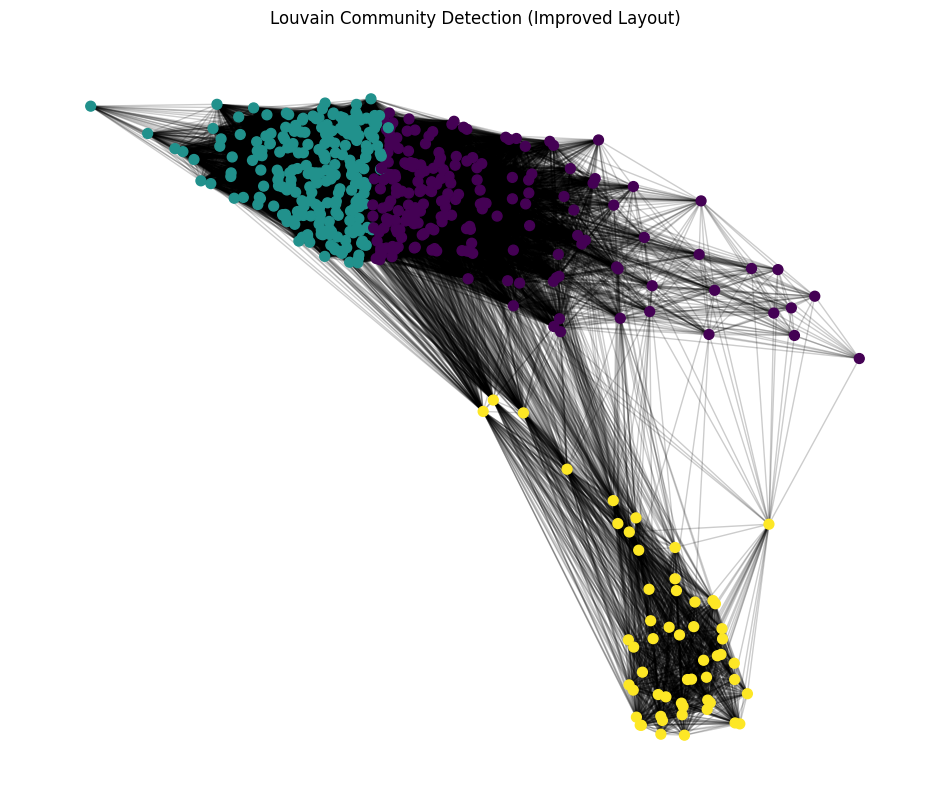

In [30]:
# Improved Louvain Community Detection Plot
partition = community_louvain.best_partition(G)
values = list(partition.values())

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)  # stable layout
nx.draw_networkx_nodes(G, pos, node_color=values, cmap=plt.cm.viridis, node_size=50)
nx.draw_networkx_edges(G, pos, alpha=0.2)
plt.title("Louvain Community Detection (Improved Layout)")
plt.axis("off")
plt.show()


In [35]:
def simulate_random_walk(G, start_node, steps=100):
    path = [start_node]
    current = start_node
    for _ in range(steps):
        neighbors = list(G.neighbors(current))
        if neighbors:
            current = np.random.choice(neighbors)
            path.append(current)
    return path

rw_path = simulate_random_walk(G, start_node=list(G.nodes())[0])
print("Random walk path sample:", rw_path[:10])



Random walk path sample: [0, np.int64(486), np.int64(443), np.int64(251), np.int64(42), np.int64(190), np.int64(168), np.int64(179), np.int64(54), np.int64(212)]


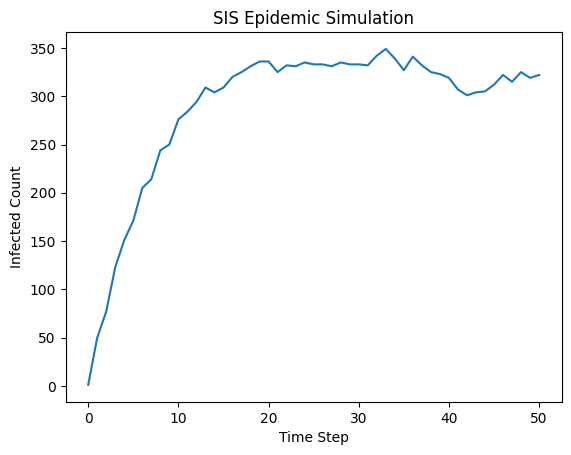

In [36]:
# SIS Epidemic Model
def simulate_sis(G, beta=0.1, gamma=0.05, steps=50):
    state = {node: 0 for node in G.nodes()}
    infected = np.random.choice(list(G.nodes()))
    state[infected] = 1
    infected_count = [1]

    for _ in range(steps):
        new_state = state.copy()
        for node in G.nodes():
            if state[node] == 1:
                if np.random.rand() < gamma:
                    new_state[node] = 0
            else:
                neighbors = list(G.neighbors(node))
                if any(state[neigh] == 1 for neigh in neighbors):
                    if np.random.rand() < beta:
                        new_state[node] = 1
        state = new_state
        infected_count.append(sum(state.values()))

    plt.plot(infected_count)
    plt.title("SIS Epidemic Simulation")
    plt.xlabel("Time Step")
    plt.ylabel("Infected Count")
    plt.show()

simulate_sis(G)


In [45]:
import datetime

times = pd.date_range(start='2025-01-01', periods=len(G.edges()), freq='D')
time_graph = nx.DiGraph()

for (u, v), t in zip(G.edges(), times):
    time_graph.add_edge(u, v, time=t.strftime('%Y-%m-%d'))

print("Sample of temporal edges:")
for u, v, data in list(time_graph.edges(data=True))[:5]:
    print(f"{u} -> {v} at {data['time']}")

Sample of temporal edges:
0 -> 1 at 2025-01-01
0 -> 4 at 2025-01-02
1 -> 2 at 2025-01-03
2 -> 3 at 2025-01-04
3 -> 4 at 2025-01-05


In [14]:

!pip install networkx matplotlib pandas seaborn community --quiet

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from networkx.algorithms import community
import community as community_louvain


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


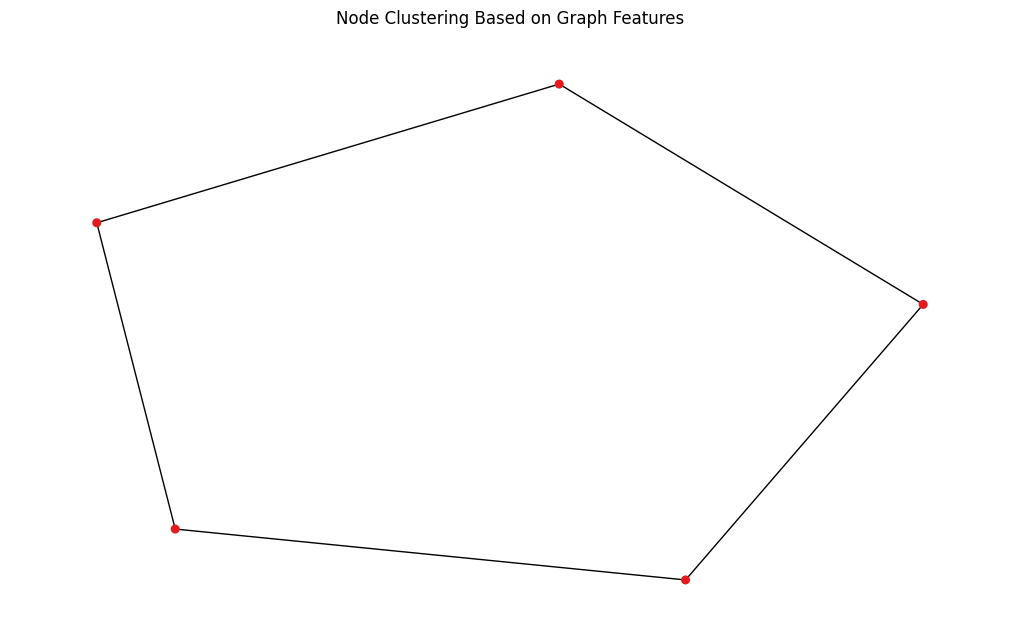

In [56]:
from sklearn.cluster import KMeans

# Extract node features
node_features = pd.DataFrame({
    'degree': dict(G.degree()),
    'closeness': nx.closeness_centrality(G),
    'betweenness': nx.betweenness_centrality(G),
    'clustering': nx.clustering(G),
})

# Apply clustering
kmeans = KMeans(n_clusters=3, random_state=42)
node_features['cluster'] = kmeans.fit_predict(node_features)

# Visualize clusters
plt.figure(figsize=(10, 6))
nx.draw_spring(G, node_color=node_features['cluster'], node_size=30, cmap=plt.cm.Set1, with_labels=False)
plt.title("Node Clustering Based on Graph Features")
plt.show()


In [62]:
pageranks = nx.pagerank(G)
top_pagerank = sorted(pageranks.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes by PageRank:", top_pagerank)




Top 10 nodes by PageRank: [(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0.2)]


In [64]:
nx.write_gexf(G, "compound_graph.gexf")
from google.colab import files
files.download("compound_graph.gexf")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

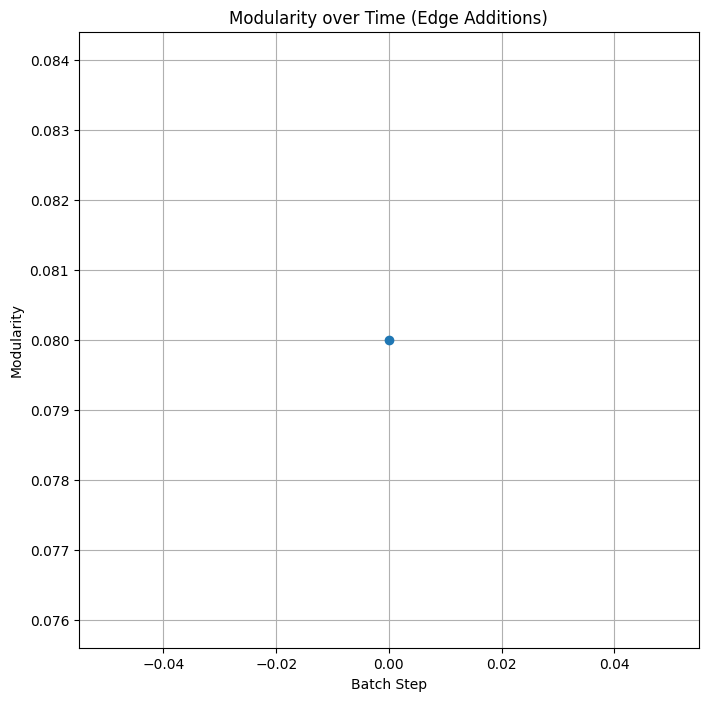

In [66]:
from copy import deepcopy

# Simulate evolution by adding edges in batches
def dynamic_communities_simulation(G, batch_size=50):
    all_edges = list(G.edges())
    np.random.shuffle(all_edges)

    G_dynamic = nx.Graph()
    G_dynamic.add_nodes_from(G.nodes())
    modularities = []

    for i in range(0, len(all_edges), batch_size):
        G_dynamic.add_edges_from(all_edges[i:i+batch_size])
        partition = community_louvain.best_partition(G_dynamic)
        modularity = community.modularity(G_dynamic, [set(np.where(np.array(list(partition.values())) == c)[0]) for c in set(partition.values())])
        modularities.append(modularity)

    plt.plot(modularities, marker='o')
    plt.title("Modularity over Time (Edge Additions)")
    plt.xlabel("Batch Step")
    plt.ylabel("Modularity")
    plt.grid(True)
    plt.show()

dynamic_communities_simulation(G)



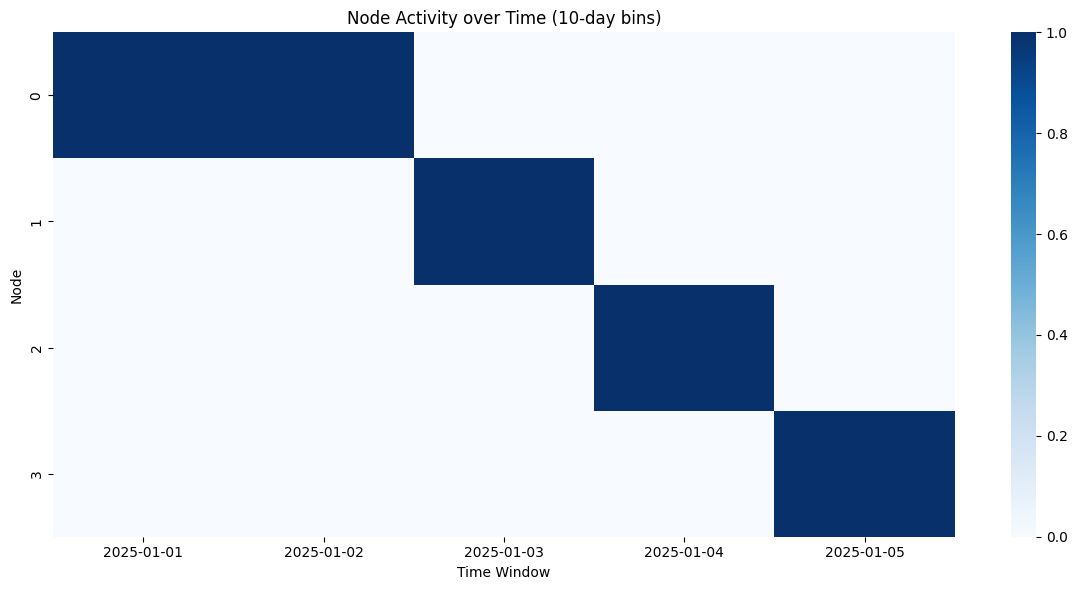

In [67]:
# Convert edge list into DataFrame
edges_df = pd.DataFrame([(u, v, d['time']) for u, v, d in time_graph.edges(data=True)], columns=['source', 'target', 'time'])
edges_df['time'] = pd.to_datetime(edges_df['time'])

# Rolling 10-day window degree count
edges_df['window'] = edges_df['time'].dt.to_period('10D')
activity = edges_df.groupby(['window', 'source']).size().unstack(fill_value=0)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(activity.T, cmap='Blues')
plt.title("Node Activity over Time (10-day bins)")
plt.xlabel("Time Window")
plt.ylabel("Node")
plt.tight_layout()
plt.show()


In [68]:
def simulate_diffusion(time_graph, source_node, delay=5):
    activated = {source_node: pd.Timestamp("2025-01-01")}
    for u, v, d in sorted(time_graph.edges(data=True), key=lambda x: x[2]['time']):
        t = pd.to_datetime(d['time'])
        if u in activated and (t - activated[u]).days <= delay:
            if v not in activated:
                activated[v] = t
    return activated

activated_nodes = simulate_diffusion(time_graph, source_node=list(G.nodes())[0])
print(f"Total activated nodes: {len(activated_nodes)}")


Total activated nodes: 5


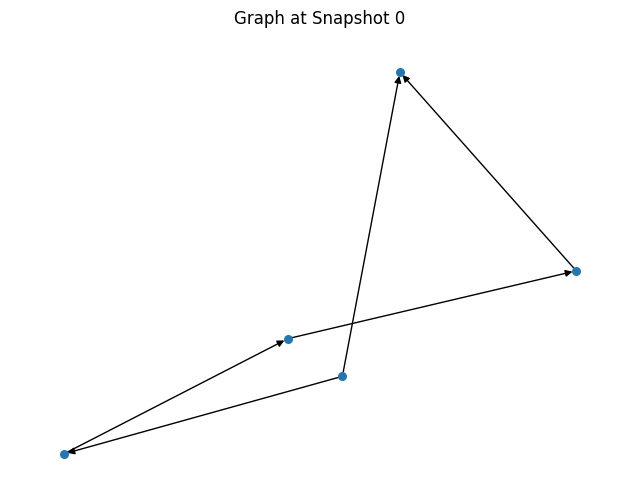

In [72]:
from matplotlib import animation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(8, 6))

def update(i):
    ax.clear()
    nx.draw(snapshots[i], ax=ax, with_labels=False, node_size=30)
    ax.set_title(f"Graph at Snapshot {i}")

ani = animation.FuncAnimation(fig, update, frames=len(snapshots), interval=800)
HTML(ani.to_jshtml())



Max k-core: 2


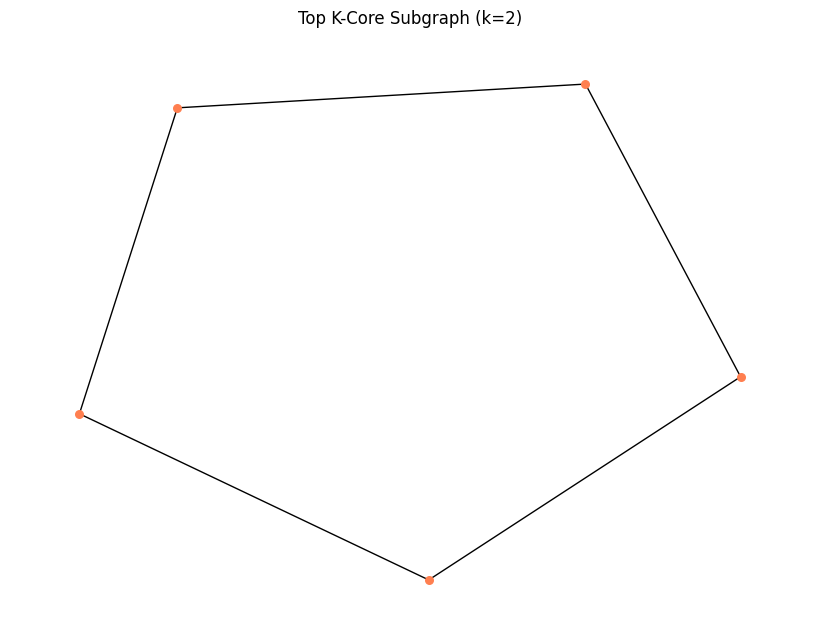

In [75]:
# K-core decomposition
core_numbers = nx.core_number(G)
max_core = max(core_numbers.values())
print(f"Max k-core: {max_core}")

# Visualize top core
core_subgraph = nx.k_core(G, k=max_core)
plt.figure(figsize=(8, 6))
nx.draw_spring(core_subgraph, with_labels=False, node_size=30, node_color='coral')
plt.title(f"Top K-Core Subgraph (k={max_core})")
plt.show()



Text(0.5, 1.0, 'Louvain Community Detection')

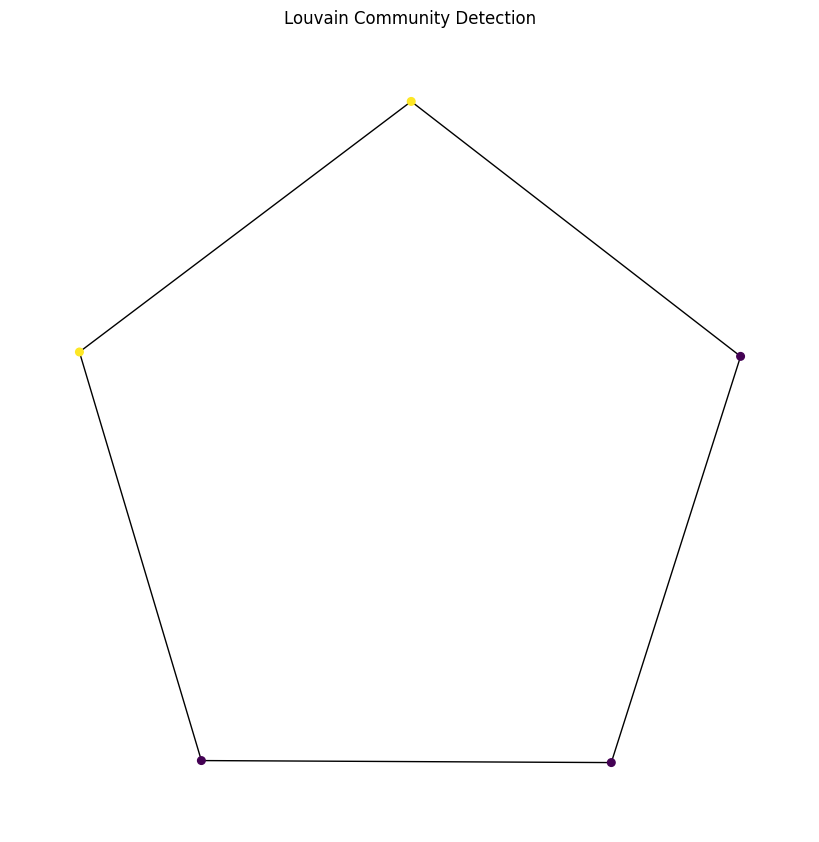

In [82]:
partition = community_louvain.best_partition(G)
values = list(partition.values())
nx.draw_spring(G, node_color=values, with_labels=False, node_size=30, cmap=plt.cm.viridis)
plt.title("Louvain Community Detection")
